# CS7641 Machine Learning
*Application of Machine Learning in Pairs Trading*

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

## Generate the input data

### Price history

Merge the price history of the all periods

In [56]:
# data as a training data.
training_set = pd.read_csv("data_trade.csv")
pairs_list = [['9020 JT', '9022 JT'], ['8801 JT', '8802 JT']]

training_set.drop('ticker', axis=1, inplace=True)
training_set.T
date=training_set.T.index
date=pd.to_datetime(date)
date

DatetimeIndex(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-21',
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-28', '2017-08-29',
               ...
               '2024-02-21', '2024-02-22', '2024-02-26', '2024-02-27',
               '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-04',
               '2024-03-05', '2024-03-06'],
              dtype='datetime64[ns]', length=1599, freq=None)

In [44]:
for i in range(len(pairs_list)):
    if i==0:
        training_pair_set = \
            training_set.loc[training_set['ticker']==pairs_list[0][0]]
        training_pair_set = pd.concat([training_pair_set, 
                   training_set.loc[training_set['ticker']==pairs_list[0][1]]])
    else:
        training_pair_set = pd.concat([training_pair_set,
                   training_set.loc[training_set['ticker']==pairs_list[i][0]]])
        training_pair_set = pd.concat([training_pair_set,
                   training_set.loc[training_set['ticker']==pairs_list[i][1]]])

training_pair_set = training_pair_set.reset_index()
training_pair_set = training_pair_set.drop(columns=['index'])
#print(training_pair_set)
training_pair_set.head()

,ticker,2017-08-16,2017-08-17,2017-08-18,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-28,...,2024-02-21,2024-02-22,2024-02-26,2024-02-27,2024-02-28,2024-02-29,2024-03-01,2024-03-04,2024-03-05,2024-03-06
0,9020 JT,9484.69,9379.81,9311.41,9329.65,9206.53,9215.65,9129.01,9119.89,9156.37,...,8955.0,9020.0,9043.0,8912.0,8850.0,8865.0,8914.0,8784.0,8788.0,8793.0
1,9022 JT,3510.92,3502.34,3471.84,3471.84,3451.83,3461.36,3464.22,3454.69,3471.84,...,3775.0,3803.0,3825.0,3779.0,3761.0,3769.0,3767.0,3735.0,3794.0,3795.0
2,8801 JT,2115.71,2111.31,2076.52,2074.76,2089.29,2078.72,2092.37,2083.12,2087.09,...,4051.0,4129.0,4140.0,4103.0,4015.0,4061.0,4144.0,4234.0,4220.0,4275.0
3,8802 JT,1745.44,1733.42,1695.57,1695.57,1706.26,1704.47,1689.33,1679.98,1676.42,...,2120.0,2178.0,2184.0,2230.5,2322.0,2300.5,2397.0,2423.5,2428.5,2465.5


In [105]:
class Backtesting():
    """
    Run the backtesting and track the total asset history
    """

    def __init__(self, z_score_list, stop_loss=3, buy_z=2, sell_z=-0.5, 
                 total_money=100000):
        self.pairs_num = z_score_list.shape[0]
        self.total_time = z_score_list.shape[1]
        self.stop_loss = stop_loss
        self.buy_z = buy_z
        self.sell_z = sell_z

        self.inverse_price = np.zeros((2 * self.pairs_num))
        self.total_stock = np.zeros((2 * self.pairs_num))
        self.total_inverse = np.zeros((2 * self.pairs_num))
        self.money_for_pair = int(total_money/self.pairs_num) * \
            np.ones((self.pairs_num))

    def trade_decision(self, z_score, pair_num):
        """
        Decide whether we will buy/sell the stock/inverse.
        It is decided by z-score.

        Args:
            z_score: scalar z_score value
            pair_num: pair's number
        Return:
            stock: buy(+1), sell(-1), stop_loss(-2)
            inverse: buy(+1), sell(-1), stop_loss(-2)
        """

        stop_loss = self.stop_loss
        buy_z = self.buy_z
        sell_z = self.sell_z
        total_stock = self.total_stock[2 * pair_num]
        total_inverse = self.total_inverse[2 * pair_num]
        stock, inverse = 0, 0

        # Need to sell everything to stop loss
        if z_score >= stop_loss or z_score <= -1*stop_loss:
            stock, inverse = -2, -2

        # If the z-score is over the buy_z, buy the stock a
        elif z_score >= buy_z and total_stock == 0:
            stock, inverse = 1, 0
        
        # If the z-score below sell_z, sell all the stocks to make profit 
        elif z_score <= sell_z and total_stock > 0:
            stock, inverse = -1, 0

        # If the z-score below -1 * buy_z, buy the inverse a
        elif z_score <= -1 * buy_z and total_inverse == 0:
            stock, inverse = 0, 1

        # If the z-score above -1 * sell_z, sell the inverse a to make profit
        elif z_score >= -1 * sell_z and total_inverse > 0:
            stock, inverse = 0, -1
        
        return stock, inverse


    def cal_trade_vol(self, stock_num, stock_signal, inv_signal, current_price):
        """
        Calculate the volume of trade we will trade

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_signal: Signal to trade the stock (+: buy, -: sell)
            inv_signal: Signal to trade the inverse (+: buy, -: sell)
            current_price: current price to calculate how many stock we will 
                trade
        Return:
            trade_stock_vol: Volume of stock to buy(+) or sell(-)
            trade_inverse_vol: Volume of inverse to buy(+) or sell(-)
        """

        # Initialization
        trade_stock_vol = 0
        trade_inverse_vol = 0

        # Calculate how much money we will use for this stock
        money_for_stock = self.money_for_pair[int(stock_num/2)] / 2

        # Sell the stock if the stock_signal < 0
        if stock_signal < 0:
            trade_stock_vol = -1 * self.total_stock[stock_num]

        # Buy the stock if the stock_signal > 0
        elif stock_signal > 0:
            trade_stock_vol = int(money_for_stock/current_price)

        # Sell the inverse if the inverse_signal < 0
        if inv_signal < 0:
            trade_inverse_vol = -1 * self.total_inverse[stock_num]

        # Buy the stock if the inverse_signal > 0
        elif inv_signal > 0:
            trade_inv_vol = int(money_for_stock/current_price)

        return trade_stock_vol, trade_inverse_vol
        
    def cal_result(self, stock_num, stock_vol, inverse_vol, prev_price, current_price):
        """
        Calculate the each stock's trade results

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_vol: Volume of stock to buy(+) or sell(-)
            inverse_vol: Volume of inverse to buy(+) or sell(-)
            prev_price: Price of the stock the day before.
            current_price: Price of the stock today.
        Return:
            total_asset: Sum of all the assets today.
        """

        # Update the price of current inverse
        if self.total_inverse[stock_num] > 0:
            change_ratio = (current_price - prev_price) / prev_price
            self.inverse_price[stock_num] = (1 - change_ratio) * self.inverse_price[stock_num]
        
        # Buy the stock
        if stock_vol > 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price

        # Sell the stock
        elif stock_vol < 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price
        
        # Buy the inverse
        if inverse_vol > 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_price
            self.inverse_price[stock_num] = current_price
        
        # Sell the inverse
        if inverse_vol < 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * self.inverse_price[stock_num]
            self.inverse_price[stock_num] = 0

        total_asset = (self.total_inverse[stock_num] * self.inverse_price[stock_num] + 
                          self.total_stock[stock_num] * current_price)

        return total_asset


    def backtesting(self, z_score_list, price_list):
        """
        Args:
            z_score_list: list of z-score history (NxT).
            price_list: list of price history (2NxT).
        Return:
            final asset history
        """

        total_asset = np.zeros((self.pairs_num, self.total_time))

        for t in range(self.total_time):
            for pair_num in range(self.pairs_num):
                stock_a_num = 2*pair_num
                stock_b_num = 2*pair_num+1
                z_score = z_score_list[pair_num]
            
                # Decide whether buy or sell stock a.
                stock_a, inverse_a = self.trade_decision(
                    z_score[t], pair_num)
                stock_b = inverse_a
                inverse_b = stock_a

                # Calculate the buy/sell volume
                stock_a_vol, inverse_a_vol = self.cal_trade_vol(
                    stock_a_num, stock_a, inverse_a, price_list[stock_a_num][t])
                stock_b_vol, inverse_b_vol = self.cal_trade_vol(
                    stock_b_num, stock_b, inverse_b, price_list[stock_b_num][t])

                # Calculate the trade result
                total_asset[pair_num][t] += self.cal_result(stock_a_num, stock_a_vol, 
                                                  inverse_a_vol, 
                                                  price_list[stock_a_num][t-1], 
                                                  price_list[stock_a_num][t])
                
                total_asset[pair_num][t] += self.cal_result(stock_b_num, stock_b_vol,
                                                     inverse_b_vol, 
                                                     price_list[stock_b_num][t-1], 
                                                     price_list[stock_b_num][t])

                total_asset[pair_num][t] += self.money_for_pair[int(pair_num)]

        return total_asset

## Run the code with pairs

Now, let's run the backtesting and get the money

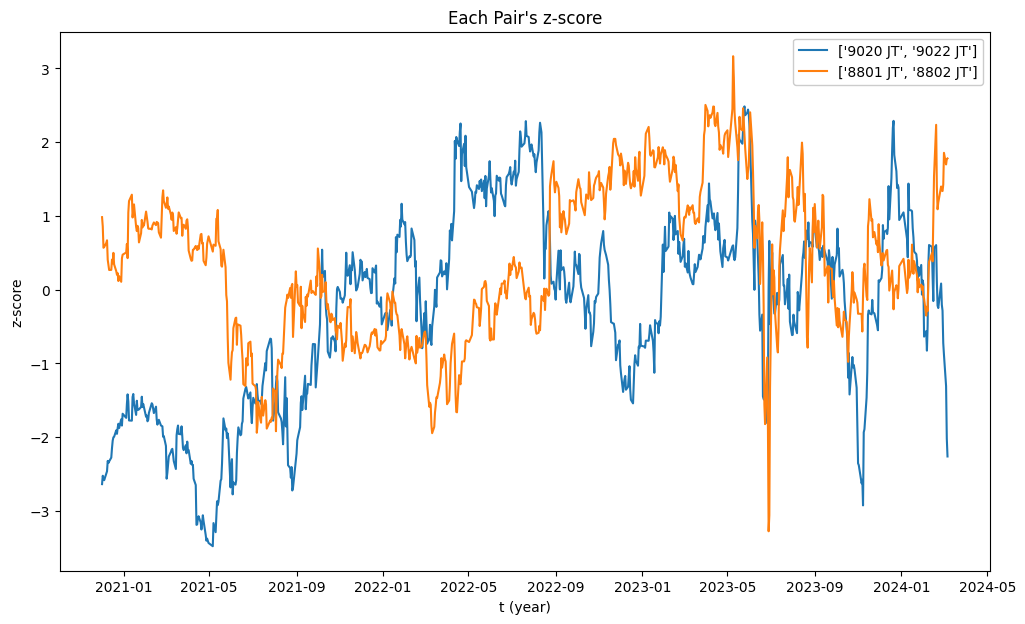

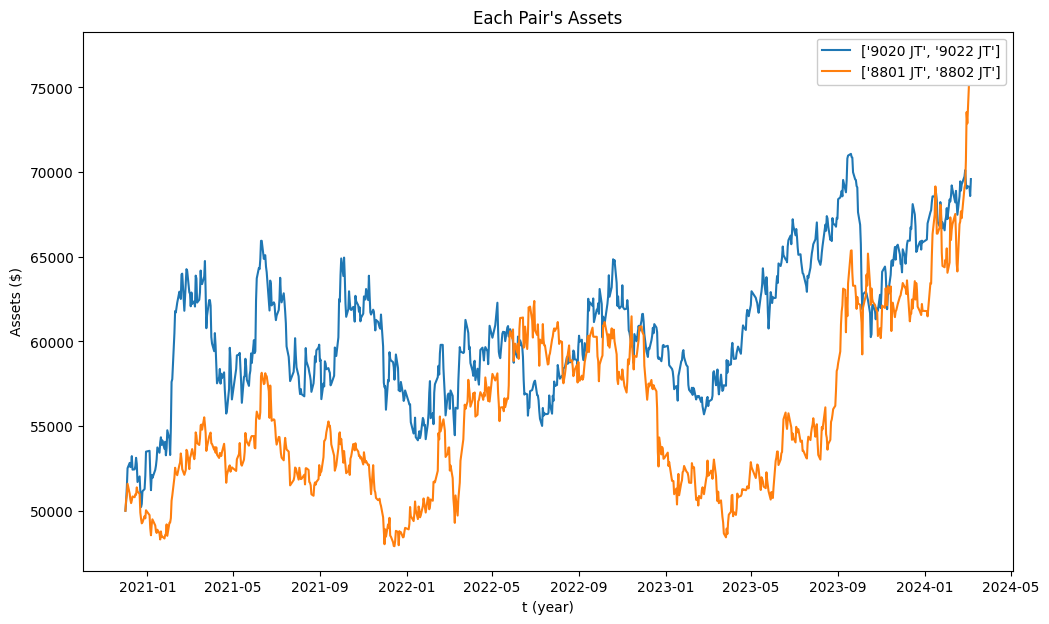

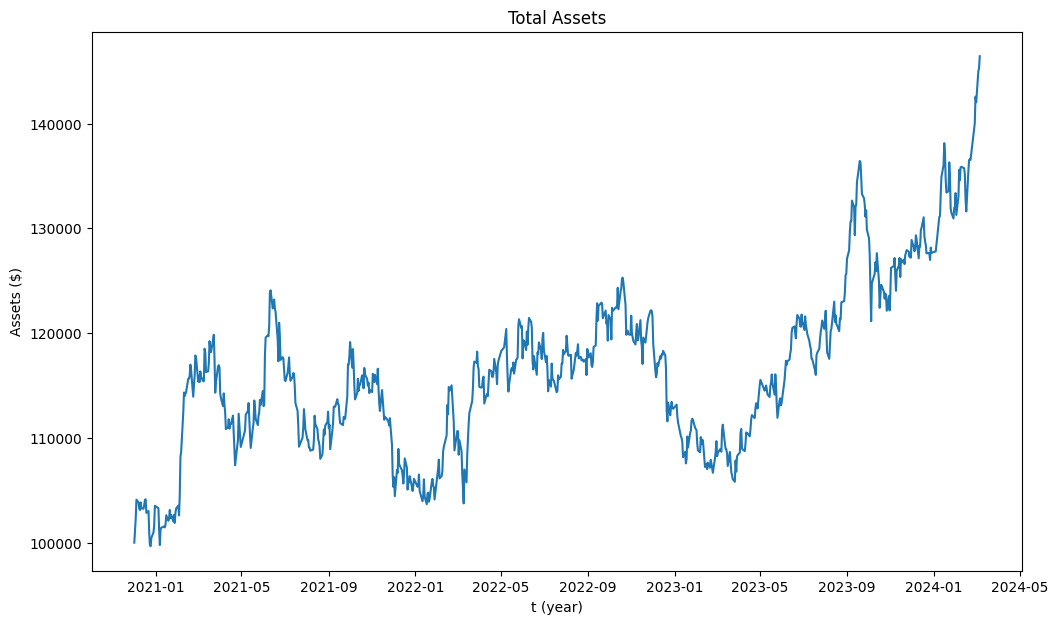

Total earning ratio: 1.4642883000000002


In [163]:
# Read the z-score history list.
with open('z_score_history.npy', 'rb') as infile:
    z_score_list = np.load(infile)
    z_score_list = z_score_list[:len(pairs_list)]

training_set_price=training_pair_set
# Remove the initial 700 data. We generate the z-score after 700 days.
price_list = training_set_price.to_numpy()[:, 800:]

# Initial money is $100000.
initial_money = 100000

# Run the backtesting code
BT = Backtesting(z_score_list, total_money = initial_money, buy_z=0.5, sell_z=-0.7, stop_loss=5)
asset_per_pair = BT.backtesting(z_score_list, price_list)

# Plot the graphs about results
x = np.arange(z_score_list.shape[1])
x = date[800:]

# Graph about each pair's z-score
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s z-score')
plt.ylabel('z-score')
plt.xlabel('t (year)')
for i, pair in enumerate(pairs_list):
    plt.plot(x, z_score_list[i], label=str(pair))
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_z_score.png')
plt.show()

# Graph about each pair's assets
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
for i, pair in enumerate(pairs_list):
    plt.plot(x, asset_per_pair[i], label=str(pair))
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_assets.png')
plt.show()

# Graph about total asset
plt.figure(figsize=(12, 7))
plt.title('Total Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
total_asset = np.sum(asset_per_pair, axis=0)
plt.plot(x, total_asset)
plt.savefig('total_assets.png')
plt.show()

# Calculate the total earning
total_earning_ratio = total_asset[-1] / initial_money
print("Total earning ratio: " + str(total_earning_ratio))

# Save the total assets
total_asset_history = pd.DataFrame(
    total_asset,
    index=x,
    columns=['total assets']
)
total_asset_history.to_csv('total_asset_history.csv', index=True)